# Tracking a maneuvering target using the RBPF

In [11]:
import dynamax
import jax.numpy as jnp
import jax.random as jr
from functools import partial

from jax import vmap, tree_map, jit
from dynamax.slds.inference import ParamsSLDS, LGParamsSLDS, DiscreteParamsSLDS, rbpfilter
from dynamax.slds.models import SLDS
# import MVN from tfd
from tensorflow_probability.substrates.jax.distributions import MultivariateNormalFullCovariance as MVN

import seaborn as sns
import matplotlib.pyplot as plt
from functools import partial
from sklearn.preprocessing import OneHotEncoder
from jax.scipy.special import logit
from mpl_toolkits.mplot3d import Axes3D
import jax

# Simulate Data

In [12]:
num_states = 3
num_particles = 1000
state_dim = 4
emission_dim = 4

TT = 0.1
A = jnp.array([[1, TT, 0, 0],
            [0, 1, 0, 0],
            [0, 0, 1, TT],
            [0, 0, 0, 1]])


B1 = jnp.array([0, 0, 0, 0])
B2 = jnp.array([-1.225, -0.35, 1.225, 0.35])
B3 = jnp.array([1.225, 0.35,  -1.225,  -0.35])
B = jnp.stack([B1, B2, B3], axis=0)

Q = 0.2 * jnp.eye(4)
R = 10.0 * jnp.diag(jnp.array([2, 1, 2, 1]))
C = jnp.eye(4)

transition_matrix = jnp.array([
    [0.8, 0.1, 0.1],
    [0.1, 0.8, 0.1],
    [0.1, 0.1, 0.8]
])

discr_params = DiscreteParamsSLDS(
    initial_distribution=jnp.ones(num_states)/num_states,
    transition_matrix=transition_matrix,
    proposal_transition_matrix=transition_matrix
)

lg_params = LGParamsSLDS(
    initial_mean=jnp.ones(state_dim),
    initial_cov=jnp.eye(state_dim),
    dynamics_weights=A,
    dynamics_cov=Q,
    dynamics_bias=jnp.array([B1, B2, B3]),
    dynamics_input_weights=None,
    emission_weights=C,
    emission_cov=R,
    emission_bias=None,
    emission_input_weights=None
)

pre_params = ParamsSLDS(
    discrete=discr_params,
    linear_gaussian=lg_params
)

params = pre_params.initialize(num_states, state_dim, emission_dim)

## Sample states and emissions
key = jr.PRNGKey(0)
slds = SLDS(num_states, state_dim, emission_dim)
dstates, cstates, emissions = slds.sample(params, key, 100)

## Filtering

In [13]:
out = rbpfilter(num_particles, params, emissions)
filtered_means = out['means']
weights = out['weights']
sampled_dstates = out['states']
post_mean = jnp.einsum("ts,tsm->tm", weights, filtered_means)

In [14]:
f = lambda t: jnp.array([jnp.sum(weights[t, jnp.where(sampled_dstates[t]==st)]) for st in range(num_states)])
p_est = jnp.array(list(map(f, jnp.arange(100))))
est_dstates = jnp.argmax(p_est, axis=1)

/Users/kostastsampourakis/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Users/kostastsampourakis/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_encoders.py:808: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/cf/9kb2d0x96lb876lx1vnj8rt40000gn/T/ipykernel_41387/504348875.py:30: MatplotlibDeprecationWarning: The w_xaxis attribute was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use xaxis instead.
  ax.w_xaxis.set_pane_color((0, 0, 0, 0))
/var/folders/cf/9kb2d0x96lb876lx1vnj8rt40000gn/T/ipykernel_41387/504348875.py:31: MatplotlibDeprecationWarning: The w_yaxis attribute was deprec

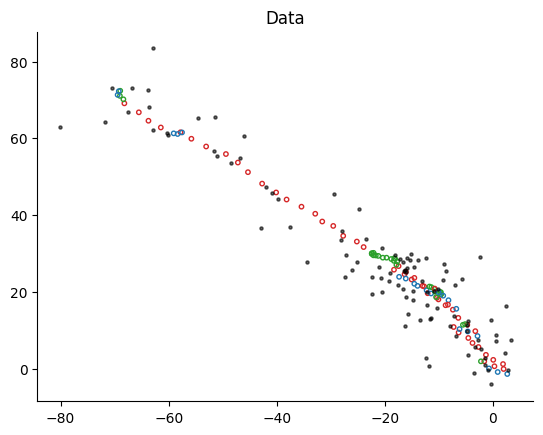

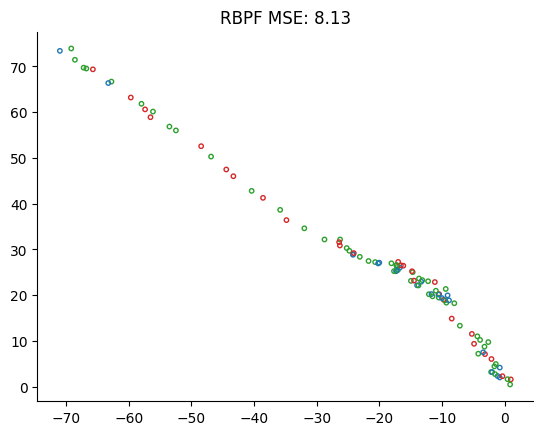

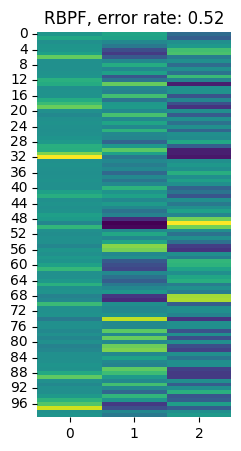

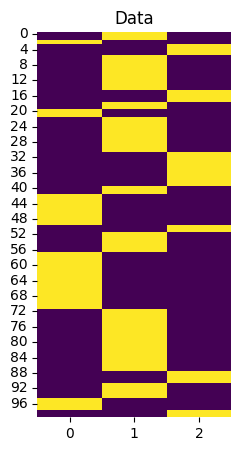

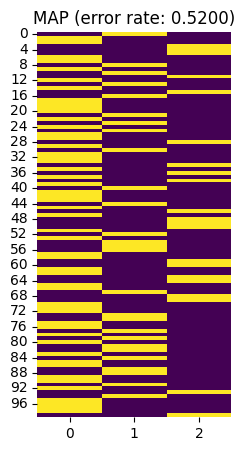

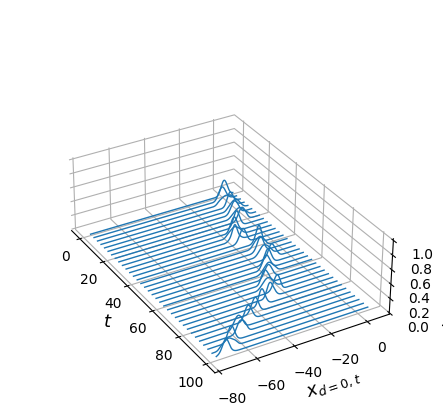

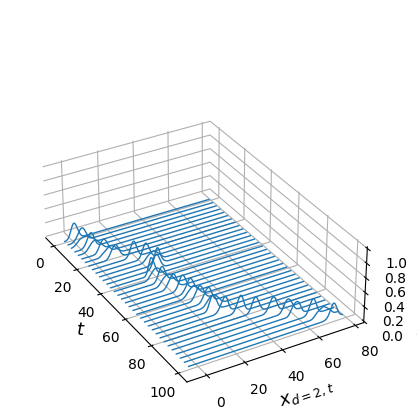

In [15]:
import numpy as np

def plot_3d_belief_state(mu_hist, dim, ax, skip=3, npoints=2000, azimuth=-30, elevation=30, h=0.5):
    nsteps = len(mu_hist)
    xmin, xmax = mu_hist[..., dim].min(), mu_hist[..., dim].max()
    xrange = np.linspace(xmin, xmax, npoints).reshape(-1, 1)
    res = np.apply_along_axis(lambda X: kdeg(xrange, X[..., None], h), 1, mu_hist)
    densities = res[..., dim]
    for t in range(0, nsteps, skip):
        tloc = t * np.ones(npoints)
        px = densities[t]
        ax.plot(tloc, xrange, px, c="tab:blue", linewidth=1)
    ax.set_zlim(0, 1)
    style3d(ax, 1.8, 1.2, 0.7, 0.8)
    ax.view_init(elevation, azimuth)
    ax.set_xlabel(r"$t$", fontsize=13)
    ax.set_ylabel(r"$x_{"f"d={dim}"",t}$", fontsize=13)
    ax.set_zlabel(r"$p(x_{d, t} \vert y_{1:t})$", fontsize=13)

def scale_3d(ax, x_scale, y_scale, z_scale, factor):    
    scale=np.diag(np.array([x_scale, y_scale, z_scale, 1.0]))
    scale=scale*(1.0/scale.max())    
    scale[3,3]=factor
    def short_proj():    
        return np.dot(Axes3D.get_proj(ax), scale)    
    return short_proj    

def style3d(ax, x_scale, y_scale, z_scale, factor=0.62):
    plt.gca().patch.set_facecolor('white')
    ax.w_xaxis.set_pane_color((0, 0, 0, 0))
    ax.w_yaxis.set_pane_color((0, 0, 0, 0))
    ax.w_zaxis.set_pane_color((0, 0, 0, 0))
    ax.get_proj = scale_3d(ax, x_scale, y_scale, z_scale, factor)

def kdeg(x, X, h):
    """
    KDE under a gaussian kernel

    Parameters
    ----------
    x: array(eval, D)
    X: array(obs, D)
    h: float

    Returns
    -------
    array(eval):
        KDE around the observed values
    """
    N, D = X.shape
    nden, _ = x.shape

    Xhat = X.reshape(D, 1, N)
    xhat = x.reshape(D, nden, 1)
    u = xhat - Xhat
    u = np.linalg.norm(u, ord=2, axis=0) ** 2 / (2 * h ** 2)
    px = np.exp(-u).sum(axis=1) / (N * h * np.sqrt(2 * np.pi))
    return px


 # Plot target dataset
dict_figures = {}
color_dict = {0: "tab:green", 1: "tab:red", 2: "tab:blue"}
fig, ax = plt.subplots()
color_states_org = [color_dict[int(state)] for state in dstates]
ax.scatter(*cstates[:, [0, 2]].T, c="none", edgecolors=color_states_org, s=10)
ax.scatter(*emissions[:, [0, 2]].T, s=5, c="black", alpha=0.6)
ax.set_title("Data")
dict_figures["rbpf-maneuver-data"] = fig

# Plot filtered dataset
fig, ax = plt.subplots()
rbpf_mse = ((post_mean - cstates)[:, [0, 2]] ** 2).mean(axis=0).sum()
color_states_est = [color_dict[int(state)] for state in np.array(est_dstates)]
ax.scatter(*post_mean[:, [0, 2]].T, c="none", edgecolors=color_states_est, s=10)
ax.set_title(f"RBPF MSE: {rbpf_mse:.2f}")
dict_figures["rbpf-maneuver-trace"] = fig

# Plot belief state of discrete system
rbpf_error_rate = (dstates != est_dstates).mean()
fig, ax = plt.subplots(figsize=(2.5, 5))
sns.heatmap(p_est, cmap="viridis", cbar=False)
plt.title(f"RBPF, error rate: {rbpf_error_rate:0.3}")
dict_figures["rbpf-maneuver-discrete-belief"] = fig

# Plot ground truth and MAP estimate
ohe = OneHotEncoder(sparse=False)
latent_hmap = ohe.fit_transform(dstates[:, None])
latent_hmap_est = ohe.fit_transform(p_est.argmax(axis=1)[:, None])

fig, ax = plt.subplots(figsize=(2.5, 5))
sns.heatmap(latent_hmap, cmap="viridis", cbar=False, ax=ax)
ax.set_title("Data")
dict_figures["rbpf-maneuver-discrete-ground-truth.pdf"] = fig

fig, ax = plt.subplots(figsize=(2.5, 5))
sns.heatmap(latent_hmap_est, cmap="viridis", cbar=False, ax=ax)
ax.set_title(f"MAP (error rate: {rbpf_error_rate:0.4f})")
dict_figures["rbpf-maneuver-discrete-map"] = fig

# Plot belief for state space
dims = [0, 2]
for dim in dims:
    fig = plt.figure()
    ax = plt.axes(projection="3d")
    plot_3d_belief_state(filtered_means, dim, ax, h=1.1)
    # pml.savefig(f"rbpf-maneuver-belief-states-dim{dim}.pdf", pad_inches=0, bbox_inches="tight")
    dict_figures[f"rbpf-maneuver-belief-states-dim{dim}.pdf"] = fig


plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.show()